<a href="https://colab.research.google.com/github/JimmyKurui/nairobi-water-demand-forecast-model/blob/main/IS_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Water Use Prediction Model for Nairobi County**

This ANN model utilizes data acquired from Nairobi Water and Sewerage Corporation (NWSC), the county's main supplier and distributer of piped water to predict short term water consumption rates in different residential areas

# Data Preparation

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam, Adagrad, Adadelta
from sklearn.feature_selection import mutual_info_classif     #Correlation
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler  #To normalize data
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor   # To test multicollinearity

## Dataset

In [14]:
# Water Meter Data 
df = pd.read_excel("/content/Feature_Set.xlsx")
# df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/IS Project II/water_datasets/Feature_Set.xlsx")
df.head(5)


,month,average_wage,population,hh_size,volume,total_bill,temp_max ('C),temp_min ('C),radiation (MJ/m2)_sw,rain (mm)
0,2018-12-01,64854.0,1047321,3.9,2119368.38,3.010247e+08,658.2,342.8,634.87,70.7
1,2018-11-01,64854.0,1047114,3.9,2484161.22,3.528381e+08,650.8,333.1,650.91,31.4
2,2018-10-01,64854.0,1047819,3.9,2222954.67,3.157376e+08,650.1,338.7,629.63,63.1
3,2018-09-01,64854.0,1054165,3.9,2463066.65,3.498419e+08,614.5,295.9,670.76,23.5
4,2018-08-01,64854.0,1047114,3.9,2246023.51,3.190142e+08,560.6,280.7,545.24,34.4


In [15]:
df['month'] = pd.to_datetime(df['month'])
df.sort_values(by='month', inplace=True)
df.head(5)

,month,average_wage,population,hh_size,volume,total_bill,temp_max ('C),temp_min ('C),radiation (MJ/m2)_sw,rain (mm)
131,2008-01-01,30551.13,713745,4.18,1306416.727,2.006169e+08,717.9,317.4,737.66,34.6
130,2008-02-01,30551.13,714604,4.18,2047460.354,3.144134e+08,661.4,294.5,702.44,24.7
129,2008-03-01,30551.13,713235,4.18,1838093.277,2.822624e+08,692.3,339.0,687.53,180.1
128,2008-04-01,30551.13,713782,4.18,2113456.875,3.245480e+08,613.8,333.1,610.96,71.1
127,2008-05-01,30551.13,713901,4.18,1509673.521,2.318295e+08,603.7,330.3,587.02,37.1


In [16]:
# Data types
df.dtypes

month                   datetime64[ns]
average_wage                   float64
population                       int64
hh_size                        float64
volume                         float64
total_bill                     float64
temp_max ('C)                  float64
temp_min ('C)                  float64
radiation (MJ/m2)_sw           float64
rain (mm)                      float64
dtype: object

# Data Preprocessing 

In [17]:
df_nomonth = df.drop('month', axis=1)

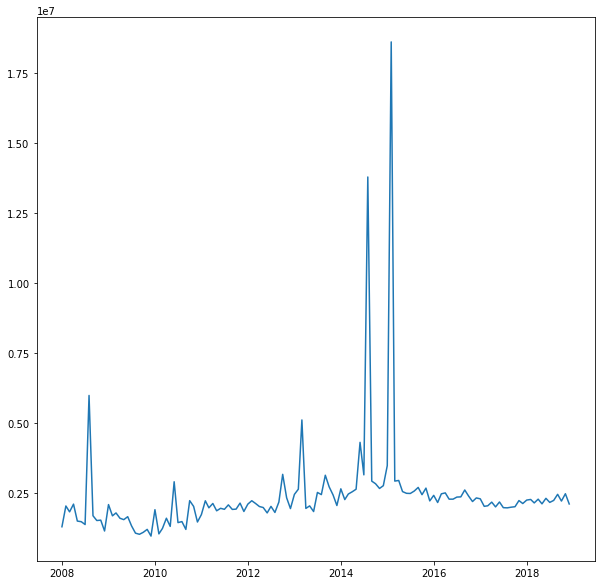

In [18]:
# Sample plot of a volume time series
plt.figure(figsize=(10,10))
plt.plot(df['month'], df['volume'])

# for i in df_nomonth.columns:
#   plt.subplot(df['month'])
# plt.show()
# sns.lineplot(df, time='Date')

## Normalization

Normalization reduces: 
- Bias-variance trade-off
- Reduces computational expense

A natural log function is used to reduce the effect of large numbers and make the feature inter-relationship more linear


In [19]:
# 1. Log transform
data = df_nomonth.columns.drop("volume")
target = ['volume']

df_trans = df
df_trans[df_nomonth.columns] = df_nomonth.apply(np.log)
df_trans.head(2)

,month,average_wage,population,hh_size,volume,total_bill,temp_max ('C),temp_min ('C),radiation (MJ/m2)_sw,rain (mm)
131,2008-01-01,10.327157,13.478281,1.430311,14.082799,19.116908,6.576330,5.760163,6.603483,3.543854
130,2008-02-01,10.327157,13.479484,1.430311,14.532111,19.566219,6.494359,5.685279,6.554560,3.206803


In [20]:
# 2. Standard Scaler

scaler = StandardScaler()
df_trans[df_nomonth.columns] = scaler.fit_transform(df_nomonth)
df_trans.head(1)
df_nomonth = df_trans.drop('month',axis=1)


## Cleaning

In [21]:
# Empty columns
df_trans.dropna(how='all', axis=1 , inplace=True) 

# Empty rows
df_trans.dropna(how='all', axis=0 , inplace=True) 

In [22]:
# Fill for NaN Values
for i in df_trans:
    if(df_trans[i].isna):
       df_trans[i].fillna( method ='bfill', inplace = True)

In [23]:
# Check the data for any errors or inconsistencies
for col in df_nomonth:
    # i) Check for any values that are too large or too small
    if df_nomonth[col].min() < -9999999 or df_nomonth[col].max() > 9999999:
        print(f'Found large values in column {col}')

    # ii) Check for any values that are not in the expected format
    if df_nomonth[col].dtype not in [int, float, np.datetime64]:
        print(f'Found unexpected data type in column: {col}')

In [24]:
def remove_outliers_iqr(data):
  # Convert the input data to a NumPy array
  data = np.array(data)

  # Calculate the number of rows and columns in the data
  rows, cols = data.shape

  # Initialize an empty list to store the lower and upper bounds for each column
  lower_bounds = []
  upper_bounds = []

  # Calculate the lower and upper bounds for each column
  for col in range(cols):
    # Calculate quartiles for the column
    q1, q3 = np.percentile(data[:, col], [25, 75])

    # Calculate the interquartile range for the column
    iqr = q3 - q1

    # Set the lower and upper bounds for the column
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Add the bounds to the lists
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)

  # Convert the lists to NumPy arrays
  lower_bounds = np.array(lower_bounds)
  upper_bounds = np.array(upper_bounds)

  # Create a mask for each column to identify the outliers
  # data_clean = data[~((data < (Q1-1.5*IQR)) | (data > (Q3+1.5*IQR))).any(axis=1)]

  #find how many rows are left in the dataframe 
  # data_clean.shape

  masks = [(data[:, col] > lower_bounds[col]) & (data[:, col] < upper_bounds[col]) for col in range(cols)]

  # Combine the masks for each column using logical AND
  mask = np.logical_and.reduce(masks)

  # Return the non-outlier data points as a NumPy array
  return data[mask]


# Test the function
data = np.array([[1, 2, 3, 4, 1000, 5, 6, 7, 8], [9, 10, 11, 12, 13, 14, 15, 16, 17]])
print(remove_outliers_iqr(data))


[[   1    2    3    4 1000    5    6    7    8]
 [   9   10   11   12   13   14   15   16   17]]


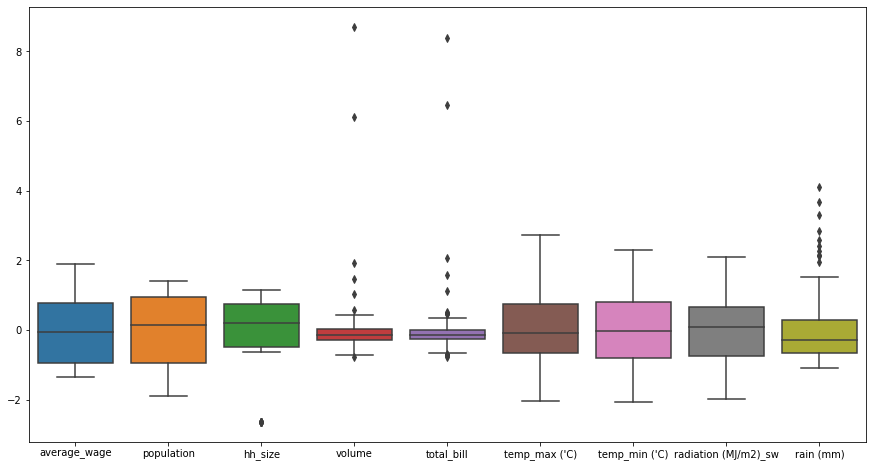

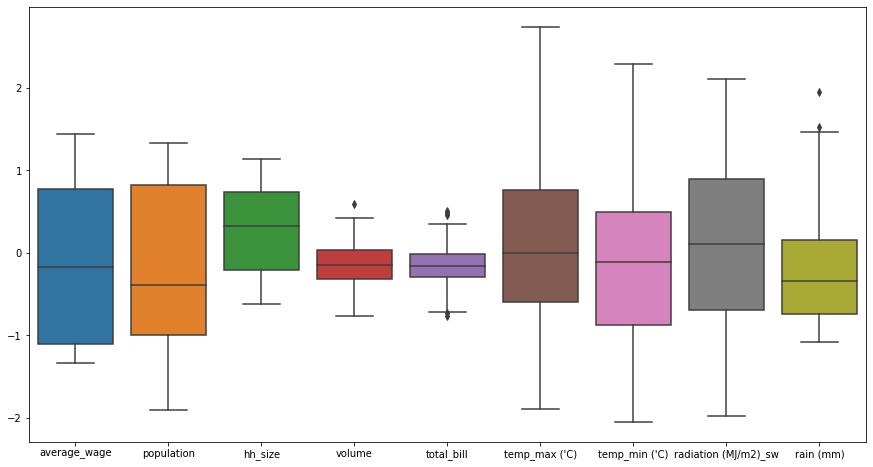

In [25]:
# Check for and handle outliers 

# Create baseline plot
plt.figure(figsize=(15,8))
sns.boxplot(data=df_trans.drop('month',axis=1))
plt.show()

# Drop outliers
df_noout = df_trans.drop(df_trans[(df_trans.volume >1) | (df_trans.hh_size < -2) | (df_trans['rain (mm)'] > 2)].index) 
df_noout.head()

# Create new plot
plt.figure(figsize=(15,8))
sns.boxplot(data=df_noout.drop('month',axis=1))
plt.show()

df_trans = df_noout
df_nomonth = df_trans.drop('month',axis=1)
# remove_outliers_iqr(df_nomonth)

# Log trans reduces effect already

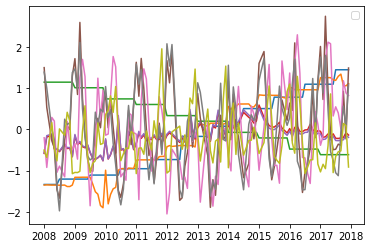

In [26]:
plt.plot(df_trans['month'], df_nomonth)
plt.legend()

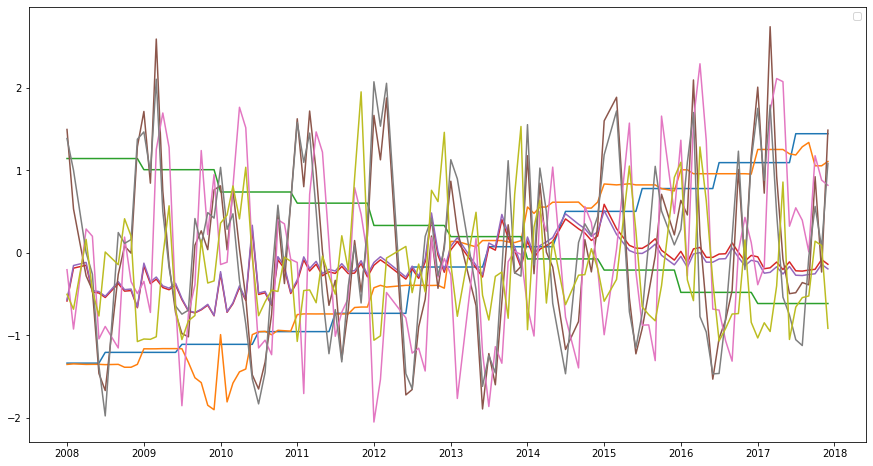

In [ ]:
# Outliers eliminated
plt.figure(figsize=(15,8))
plt.plot(df_trans['month'], df_nomonth)
plt.legend()

Using SSA for time series decomposition in order to find out relevant factoers

In [ ]:
# df_detrended = df_trans - df_trans.rolling(window=12).mean()

# # Remove missing values
# df_detrended = df_detrended.dropna()

# # Normalize the data
# df_normalized = (df_detrended - df_detrended.mean()) / df_detrended.std()

# # Set the window size and number of components
# window_size = 12
# num_components = 3

# # Perform the SSA analysis
# svd = SingularSpectrumAnalysis(n_components=3)
# X_svd = svd.fit_transform(X_scaled)

# # Extract the trend, periodic, and noise components
# trend = np.dot(U, X_svd)
# periodic = np.dot(V, X_svd)
# noise = df_trans - trend - periodic

## Feature Selection

To provide most correlating contributory factors from table of features: 6 explanatory factors included


*   Education level
*   Income level
*   Cost of piped water
*   Household size
*   Max temperature
*   Min temperature
*   Rainfall (rain + showers) 
*   Solar Radiation

In [ ]:
# Cross Correlation  to test 
importances = df_nomonth.apply(lambda x: x.corr(df_nomonth.volume))
importances.reset_index()
importances.columns = df_nomonth.columns
print(importances)

drop_indices = []
for i in importances.columns:
  if(  (-0.1<importances[i]<0.1) ):
    drop_indices.append(i)
df_clean = df_trans.drop(drop_indices, axis=1)

print(df_clean.columns)

average_wage            0.591832
population              0.686603
hh_size                -0.619171
volume                  1.000000
total_bill              0.988024
temp_max ('C)           0.051624
temp_min ('C)          -0.075284
radiation (MJ/m2)_sw    0.094720
rain (mm)              -0.000469
dtype: float64
Index(['month', 'average_wage', 'population', 'hh_size', 'volume',
       'total_bill'],
      dtype='object')


In [ ]:
# indices = importances.sort_values(False)
# names = pd.DataFrame(indices).columns
# plt.title('Correlation graph')
# plt.barh(range(len(indices)), importances[indices], color='orange', align='center')
# plt.yticks(range(len(indices)), [names[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

In [ ]:
# Muli- Collinearity in predictor variables

# Calculate the VIF for all predictor variables
vifs = []

for i, col in enumerate(df_clean[df_clean.columns.drop(['month','volume'])]):
  vif = variance_inflation_factor(df_clean[df_clean.columns.drop('month')].values, i)
  vifs.append((col, vif))

print(vifs)
df_clean = df_clean.drop(max(vifs)[0], axis=1)

vifs = []

for i, col in enumerate(df_clean[df_clean.columns.drop(['month','volume'])]):
  vif = variance_inflation_factor(df_clean[df_clean.columns.drop('month')].values, i)
  vifs.append((col, vif))
print(vifs)

[('average_wage', 25.460663833279998), ('population', 19.69336669784025), ('hh_size', 14.355492686920703), ('total_bill', 164.9781897100366)]
[('average_wage', 24.05830158392007), ('population', 19.59001503899811), ('hh_size', 13.824702303100882)]


In [ ]:
# names = pd.DataFrame(indices).columns
# plt.title('Correlation graph')
# plt.barh(range(len(indices)), importances[indices], color='orange', align='center')
# plt.yticks(range(len(indices)), [names[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

In [ ]:
# Feature extraction
df_trans = df_clean
df_nomonth = df_trans.drop('month',axis=1)
df_trans.head(2)

,month,average_wage,population,hh_size,volume,temp_min ('C)
131,2008-01-01,-1.336098,-1.351919,1.142158,-0.583747,-0.204463
130,2008-02-01,-1.336098,-1.345194,1.142158,-0.185550,-0.923043


In [ ]:
# Feature extraction no outliers
df_trans = df_clean
df_nomonth = df_trans.drop('month',axis=1)
df_trans.head(2)

,month,average_wage,population,hh_size,volume
131,2008-01-01,-1.336098,-1.351919,1.142158,-0.583747
130,2008-02-01,-1.336098,-1.345194,1.142158,-0.185550


# Training

Validation in Time Series Split

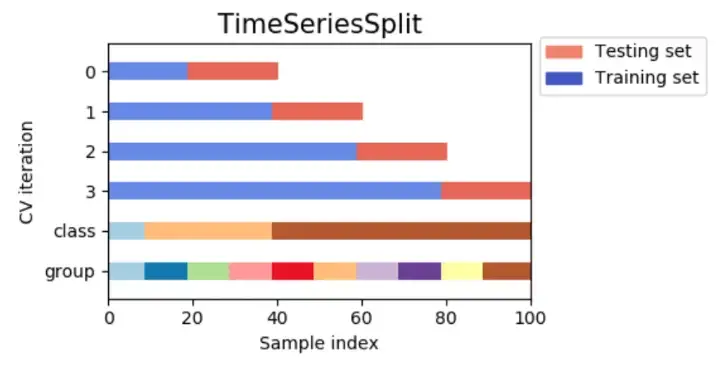

In [ ]:
# Model parameters
# TimeSeriesSplit
train = df_nomonth.iloc[: int(0.7*len(df_nomonth)), :]
test = df_nomonth.iloc[int(0.7*len(df_nomonth)) : , :]

X = train.drop('volume',axis=1)
y = train.volume

n_splits=5
lr = 0.01
itr = 500
metrics = ['accuracy']

# models = {[
#   {
#     'name': 'ANN1', 'epochs': itr, 'learning_rate': lr, 'loss': keras.optimizers.Adam        
#   } ,
#   {
#     'name': 'ANN2', 'epochs': itr, 'learning_rate': lr, 'loss': keras.optimizers.Adagrad       
#   } ,
#   {
#     'name': 'ANN3', 'epochs': itr, 'learning_rate': lr, 'loss': keras.optimizers.Adagrad        
#   } 
# ]}

# df_nomonth = df_trans.drop('month', axis=1)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 1s/step - loss: 0.8463 - accuracy: 0.0000e+00 - val_loss: 0.9307 - val_accuracy: 0.0000e+00
Epoch 2/500
1/1 [==============================] - 0s 42ms/step - loss: 0.6938 - accuracy: 0.0000e+00 - val_loss: 0.7797 - val_accuracy: 0.0000e+00
Epoch 3/500
1/1 [==============================] - 0s 64ms/step - loss: 0.5574 - accuracy: 0.0000e+00 - val_loss: 0.6441 - val_accuracy: 0.0000e+00
Epoch 4/500
1/1 [==============================] - 0s 64ms/step - loss: 0.4372 - accuracy: 0.0000e+00 - val_loss: 0.5240 - val_accuracy: 0.0000e+00
Epoch 5/500
1/1 [==============================] - 0s 42ms/step - loss: 0.3333 - accuracy: 0.0000e+00 - val_loss: 0.4194 - val_accuracy: 0.0000e+00
Epoch 6/500
1/1 [==============================] - 0s 53ms/step - loss: 0.2455 - accuracy: 0.0000e+00 - val_loss: 0.3300 - val_accuracy: 0.0000e+00
Epoch 7/500
1/1 [==============================] - 0s 73ms/step - loss: 0.1

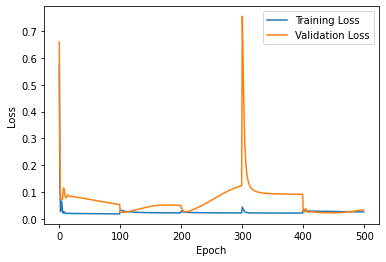

In [ ]:
# ------------------------- ANN1 ------------------------
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the model
ANN1 = keras.Sequential([
  keras.layers.Dense(12, input_shape=(X.shape[1], ), activation="tanh") ,
  keras.layers.Dense(24, activation="tanh") ,
  keras.layers.Dense(18, activation="linear") ,
  keras.layers.Dense(1) 
])

# Compile the model
ANN1.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy'])


# Iterate over the splits using TimeSeriesSplit
val_loss = []
train_loss = []
for train_index, val_index in tscv.split(train):
    # Split the data into training and val sets
    X_train, X_val = X.iloc[train_index,], X.iloc[val_index,]
    y_train, y_val = y.iloc[train_index,], y.iloc[val_index,]
  
    # Train the model and collect the training and validation loss at each epoch
    history = ANN1.fit(X_train, y_train, epochs=itr, batch_size=64, validation_data=(X_val, y_val))
    train_loss += history.history['loss']
    val_loss += history.history['val_loss']
# #Plots model's training cost/loss and model's validation split cost/loss
# plt.plot(train_loss, 'b', label='Training loss')
# plt.plot(val_loss, 'r', label='val loss')
# plt.show()
avg_train_loss = [sum(train_loss[i:i+n_splits])/n_splits for i in range(0, len(train_loss), n_splits)]
avg_val_loss = [sum(val_loss[i:i+n_splits])/n_splits for i in range(0, len(val_loss), n_splits)]

# Plot the average training loss and validation loss
plt.plot(avg_train_loss, label="Training Loss")
plt.plot(avg_val_loss, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# # Plot the average training loss
# plt.plot(avg_train_loss, label="Training Loss")
# plt.legend()
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.show()

In [ ]:
#Cross Validation
print(ANN1.evaluate(X_test, y_test))
# Use cross-validation to evaluate the model's performance on each split
scores = cross_val_score(ANN1, X, y, cv=tscv)

# Print the average score across all splits
print(f'Average score: {scores.mean():.2f}')

1/1 [==============================] - 0s 61ms/step - loss: 0.8495 - accuracy: 0.0000e+00
[0.8495256304740906, 0.0]


TypeError: ignored

In [ ]:
sem1 = ((23*0.2/40) + (0.5*0.1)) * 0.5 
sem2 = 0.4 - sem1
doc = sem2* 0.6
pres = sem2 * 0.4
print(f"Doc: {doc}, Presentation: {pres}")

In [ ]:
# ------------------------- ANN2 ------------------------


# Define the model
ANN2 = keras.Sequential([
  keras.layers.Dense(12, input_shape=(df_nomonth.shape[1], ), activation="tanh") ,
  keras.layers.Dense(24, activation="tanh") ,
  keras.layers.Dense(18, activation="linear") ,
  keras.layers.Dense(1) 
])

# Compile the model
ANN2.compile(loss='mean_squared_error', optimizer=optms[2], metrics=['mae'])


# Iterate over the splits using TimeSeriesSplit
val_losses = []
losses = []
for train_index, test_index in tscv.split(df_trans):
    # Split the data into training and test sets
    X_train, X_test = df_nomonth.iloc[train_index,], df_nomonth.iloc[test_index,]
    y_train, y_test = df_nomonth.iloc[train_index,], df_nomonth.iloc[test_index,]
  
    # Train the model
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
    history = ANN2.fit(X_train, y_train, epochs=1000, batch_size=32)

    # Evaluate the model
    test_loss, loss = ANN2.evaluate(X_test, y_test)
    val_losses.append(test_loss)
    losses.append(loss)
#Plots model's training cost/loss and model's validation split cost/loss
plt.figure()
plt.plot(history.history['loss'],'bo',label='training loss')
plt.plot(test_loss,'r',label='val training loss')

In [ ]:
# ------------------------- ANN3 ------------------------


# Define the model
ANN3 = keras.Sequential([
  keras.layers.Dense(12, input_shape=(df_nomonth.shape[1], ), activation="tanh") ,
  keras.layers.Dense(24, activation="tanh") ,
  keras.layers.Dense(18, activation="linear") ,
  keras.layers.Dense(1) 
])

# Compile the model
ANN3.compile(loss='mean_squared_error', optimizer=optms[2], metrics=['mae'])


# Iterate over the splits using TimeSeriesSplit
val_losses = []
losses = []
for train_index, test_index in tscv.split(df_trans):
    # Split the data into training and test sets
    X_train, X_test = df_nomonth.iloc[train_index,], df_nomonth.iloc[test_index,]
    y_train, y_test = df_nomonth.iloc[train_index,], df_nomonth.iloc[test_index,]
  
    # Train the model
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
    history = ANN3.fit(X_train, y_train, epochs=1000, batch_size=32)

    # Evaluate the model
    test_loss, loss = ANN3.evaluate(X_test, y_test)
    val_losses.append(test_loss)
    losses.append(loss)
#Plots model's training cost/loss and model's validation split cost/loss
plt.figure()
plt.plot(history.history['loss'],'bo',label='training loss')
plt.plot(test_loss,'r',label='val training loss')

## Evaluation Validation

In [ ]:
# Evaluation
print(f"Model:  Loss,  Mean Squared Error")
print(f" ANN1 : {ANN1.evaluate(X_test, y_test)} \n ANN2 : {ANN2.evaluate(X_test, y_test)} \n ANN3 : {ANN3.evaluate(X_test, y_test)} \n")

## Optimization

Given that ANN had the best performance, mods were made to further improve its predictive capability through adjusting hyperparameters 

In [ ]:
# ------------------------- ANN1 ------------------------


# Define the model
ANN1 = keras.Sequential([
  keras.layers.Dense(12, input_shape=(df_nomonth.shape[1], ), activation="tanh") ,
  keras.layers.Dense(24, activation="tanh") ,
  keras.layers.Dense(18, activation="linear") ,
  keras.layers.Dense(1) 
])

# Compile the model
ANN1.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=learning_rate), metrics=['mae'])


# Iterate over the splits using TimeSeriesSplit
val_losses = []
losses = []
for train_index, test_index in tscv.split(df_trans):
    # Split the data into training and test sets
    X_train, X_test = df_nomonth.iloc[train_index,], df_nomonth.iloc[test_index,]
    y_train, y_test = df_nomonth.iloc[train_index,], df_nomonth.iloc[test_index,]
  
    # Train the model
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
    history = ANN1.fit(X_train, y_train, epochs=1000, batch_size=32)

    # Evaluate the model
    test_loss, loss = ANN1.evaluate(X_test, y_test)
    val_losses.append(test_loss)
    losses.append(loss)
#Plots model's training cost/loss and model's validation split cost/loss
plt.figure()
plt.plot(history.history['loss'],'bo',label='training loss')
plt.plot(test_loss,'r',label='val training loss')

In [ ]:
print(f" New ANN1 evaluation : {ANN1.evaluate(X_test, y_test)}")



---



# Testing



In [ ]:
y_train_pred = ANN1.predict(x_train)
y_test_pred = ANN1.predict(x_test)

y_train_pred = std_scaler.inverse_transform(y_train_pred)
y_test_pred = std_scaler.inverse_transform(y_test_pred)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

In [ ]:
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_test_pred)

plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")

# Model Save & Export


In [ ]:

# Save the entire model as a SavedModel.
model.save('nairobi_household_water_model.h5')